In this notebook, we build a Machine Learning model on the digit recognizer based on the eigenvalue features.

In [1]:
%pylab inline
pylab.style.use('ggplot')

import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

feature_file = os.path.join(os.getcwd(), 'digit_eigenvalues.csv')
data_df = pd.read_csv(feature_file)

In [3]:
# class imbalance
data_df.head()

,label,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13,eig_14,eig_15,eig_16
0,zero,15.420569,0.427869,0.151561,4.400485e-16,-7.267618e-17,-7.267618e-17,-1.208153e-16,-1.208153e-16,9.232392e-18,-6.679642e-17,6.408589e-11,-6.408578e-11,6.842278e-49,8.859278e-33,0.000000e+00,0.0
1,one,15.554091,0.222954,0.222954,-2.445276e-16,1.860237e-16,-3.848788e-17,-3.848788e-17,3.500996e-31,3.500996e-31,-2.923486e-46,-1.715385e-47,0.000000e+00,-1.531445e-61,-1.917615e-93,-2.590851e-77,0.0
2,two,15.491413,-0.914798,0.423385,2.201392e-16,2.201392e-16,-2.181684e-16,2.593635e-16,6.099706e-17,6.099706e-17,-1.662984e-18,-1.662984e-18,3.026561e-17,5.473822e-48,2.002967e-32,0.000000e+00,0.0
3,three,15.310330,-0.906107,0.122253,1.222528e-01,3.512711e-01,2.904795e-16,-1.714974e-17,-1.714974e-17,-2.929592e-16,2.095939e-17,2.095939e-17,-1.083940e-17,-3.851860e-34,-4.987330e-18,0.000000e+00,0.0
4,four,15.503790,-0.827032,0.161621,1.616207e-01,-7.396931e-17,-7.396931e-17,3.682589e-17,3.682589e-17,1.000000e+00,1.399832e-16,-1.453287e-17,6.649039e-32,-4.793997e-64,-3.373503e-80,0.000000e+00,0.0


In [4]:
data_df = data_df.set_index('label')

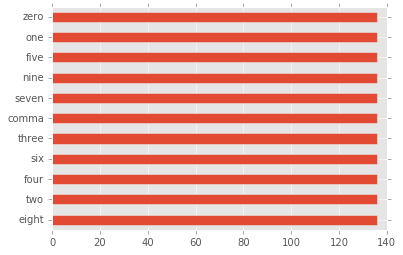

In [5]:
data_df.index.value_counts().plot(kind='barh')

In [6]:
from sklearn.feature_selection import f_classif

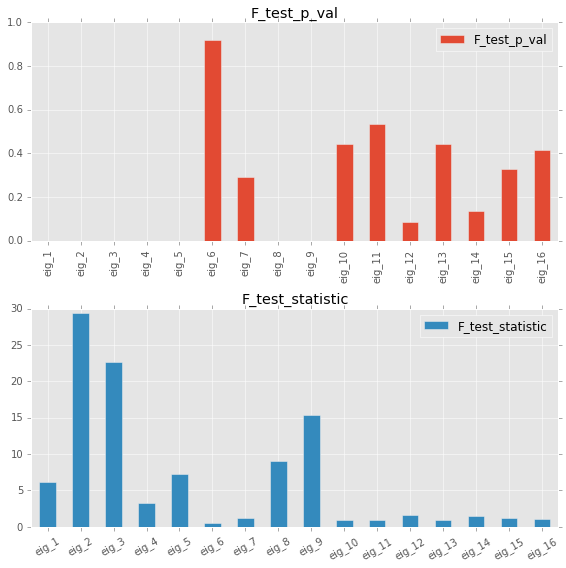

In [7]:
fig, ax = pylab.subplots(2, 1, figsize=(8, 8))
t_stats, p_vals = f_classif(data_df, data_df.index)
feature_importances = pd.DataFrame({'F_test_statistic': t_stats, 'F_test_p_val': p_vals})
feature_importances.index = data_df.columns

feature_importances.plot(kind='bar', subplots=True, ax=ax)
pylab.xticks(rotation=30)
pylab.tight_layout()

In [8]:
feature_importances[feature_importances['F_test_p_val'] < 0.05]                

,F_test_p_val,F_test_statistic
eig_1,2.972501e-09,6.153377
eig_2,6.091716e-52,29.377032
eig_3,5.547486e-40,22.700095
eig_4,2.877789e-04,3.313405
eig_5,2.659965e-11,7.268052
eig_8,1.559300e-14,9.004705
eig_9,1.575528e-26,15.404066


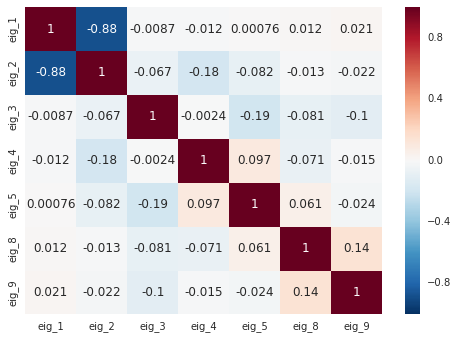

In [9]:
f_subset = feature_importances[feature_importances['F_test_p_val'] < 0.05]
relevant_features = data_df.loc[:, [str(col) for col in f_subset.index]]

rf_corrs = relevant_features.corr()

import seaborn as sns
sns.heatmap(rf_corrs, annot=True)

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

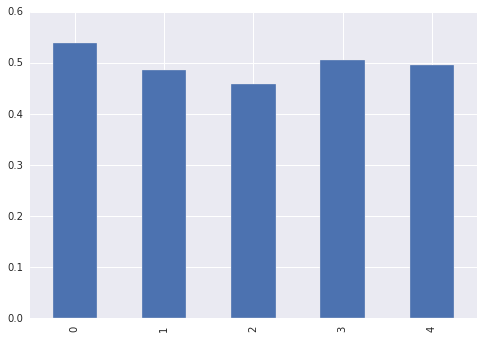

In [17]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

selector = SelectKBest(f_classif, k=7)
normalizer = StandardScaler()
estimator = SVC(C=5000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

pipeline = Pipeline([
    ('selector', selector),
    ('normalizer', normalizer),
    ('estimator', estimator),
])

scores = cross_val_score(pipeline, data_df, data_df.index, cv=cv, scoring='accuracy')

scores = pd.Series(scores)
scores.plot(kind='bar')

In [18]:
scores.mean()

0.49634439634439637

In [20]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

selector = SelectKBest(f_classif, k=7)
normalizer = StandardScaler()
estimator = SVC(C=5000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

pipeline = Pipeline([
    ('selector', selector),
    ('normalizer', normalizer),
    ('estimator', estimator),
])

predictions = cross_val_predict(pipeline, data_df, data_df.index, cv=cv)

In [24]:
report = classification_report(y_true=data_df.index.values, y_pred=predictions)
print(report)

             precision    recall  f1-score   support

      comma       0.75      0.95      0.84       136
      eight       0.43      0.46      0.44       136
       five       0.40      0.39      0.40       136
       four       0.46      0.45      0.46       136
       nine       0.44      0.35      0.39       136
        one       0.39      0.54      0.45       136
      seven       0.56      0.46      0.50       136
        six       0.56      0.57      0.56       136
      three       0.39      0.38      0.39       136
        two       0.51      0.58      0.54       136
       zero       0.55      0.35      0.42       136

avg / total       0.50      0.50      0.49      1496

